# Proximity
Brian Li \
10/28/23

This notebook contains proximity analysis of various metrics including Median Household Income for the continental US and counties + census tracts in California.

State, county, and census tract-level data were sourced from the US Census Bureau's American Community Survey via Michael Minn.

"Census tracts are subdivisions of counties that are drawn by the US Census Bureau based on clearly identifiable features to ideally contain around 4,000 residents, although in practice the range of population is usually between 1,200 and 8,000" (https://michaelminn.net/tutorials/python-proximity/#areas).

In [1]:
import geopandas as gpd
import pandas as pd
import shapely
import matplotlib.pyplot as plt

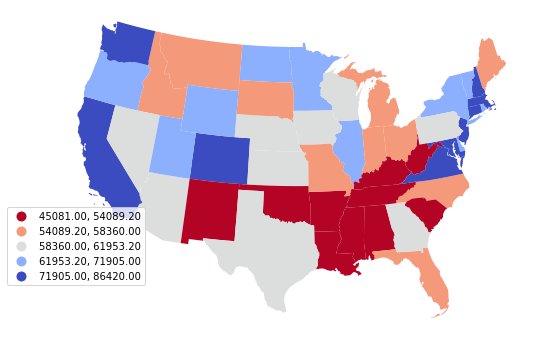

In [2]:
plt.rcParams['figure.figsize'] = [9, 6]
states = gpd.read_file("https://michaelminn.net/tutorials/data/2015-2019-acs-states.geojson")
states = states[~states["ST"].isin(['AK', 'HI', 'PR'])]
states = states.to_crs("ESRI:102008")
axis = states.plot("Median Household Income", scheme="quantiles", cmap="coolwarm_r", legend=True, edgecolor="none", legend_kwds={"bbox_to_anchor":(0.2, 0.4)})
axis.set_axis_off()
plt.show()

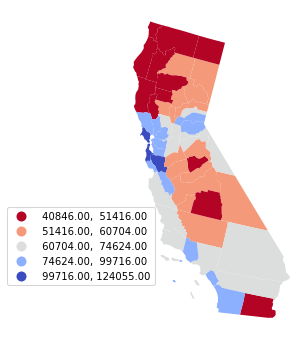

In [3]:
us_counties = gpd.read_file("https://michaelminn.net/tutorials/data/2015-2019-acs-counties.geojson")
us_counties = us_counties[~us_counties["ST"].isin(['AK', 'HI', 'PR'])]
us_counties = us_counties.to_crs(states.crs)
analysis_state = "CA"
counties = us_counties[us_counties["ST"] == analysis_state]
axis = counties.plot("Median Household Income", scheme="naturalbreaks", cmap="coolwarm_r", legend=True, edgecolor="none", legend_kwds={"bbox_to_anchor":(0.2, 0.4)})
axis.set_axis_off()
plt.show()

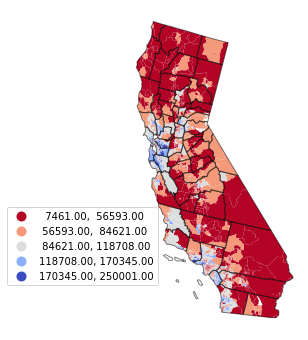

In [4]:
us_tracts = gpd.read_file("https://michaelminn.net/tutorials/data/2015-2019-acs-tracts.geojson")
tracts = us_tracts[us_tracts["ST"] == analysis_state]
tracts = tracts.to_crs(states.crs)
axis = tracts.plot("Median Household Income", scheme="naturalbreaks", cmap="coolwarm_r", legend=True, edgecolor="none", legend_kwds={"bbox_to_anchor":(0.2, 0.4)})
counties.plot(edgecolor="#00000080", facecolor="none", ax=axis)
axis.set_axis_off()
plt.show()

The transit stop data were sourced from the US Bureau of Transportation Statistics National Transportation Atlas Database.

Transit is most available in the Bay Area, Central Valley, and Socal.

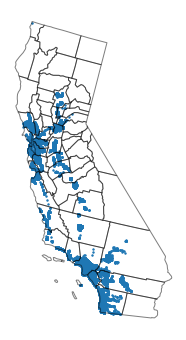

In [5]:
us_transit_stops = gpd.read_file("https://michaelminn.net/tutorials/python-proximity/2023-05-09-National_Transit_Map_Stops.geojson")
us_transit_stops = us_transit_stops.to_crs(states.crs)

transit_stops = us_transit_stops.sjoin(counties[["geometry"]])
transit_stops = transit_stops.drop(["index_right"], axis=1)
axis = transit_stops.plot(markersize = 2)
counties.plot(edgecolor="#00000080", facecolor="none", ax=axis)
axis.set_axis_off()
plt.show()

"Buffer and overlay analysis involves creating buffer polygons (usually circles) of a fixed size or radius around points that represent the area of influence around each point" (https://michaelminn.net/tutorials/python-proximity/).

"1/2 mile is commonly considered an upper limit to conveniently walk to transit, although that is an arbitrary Euclidean choice that can be limited by obstacles like highways or the absence of sidewalks" (https://michaelminn.net/tutorials/python-proximity/).

The map below displays transit in Los Angeles County, primarily managed by LACMTA (https://www.metro.net/)

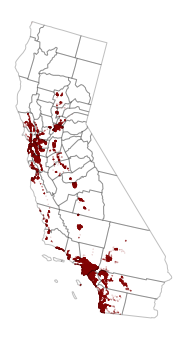

In [6]:
transit_buffers = transit_stops.copy()
transit_buffers["geometry"] = transit_stops.buffer(800)
axis = transit_buffers.plot(edgecolor="#80000040", facecolor="none")
counties.plot(edgecolor="#00000040", facecolor="none", ax=axis)
axis.set_axis_off()
plt.show()

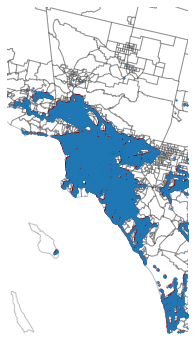

In [8]:
zoom = counties[counties["Name"] == "Los Angeles"]
axis = tracts.plot(edgecolor="#00000040", facecolor="none")
transit_buffers.plot(edgecolor="#80000040", facecolor="none", ax=axis)
transit_stops.plot(markersize=1, ax=axis)
axis.set_xlim(zoom.total_bounds[0], zoom.total_bounds[2])
axis.set_ylim(zoom.total_bounds[1], zoom.total_bounds[3])
axis.set_axis_off()
plt.show()

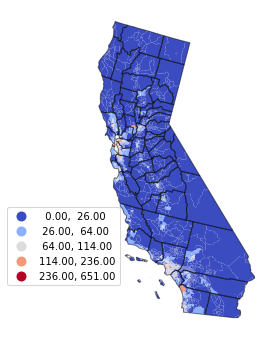

In [10]:
transit_buffers = transit_stops.copy()
transit_buffers["geometry"] = transit_stops.buffer(800)
transit_tracts = transit_buffers.sjoin(tracts)
transit_tracts["Stop Count"] = 1
transit_tracts = transit_tracts.groupby("FactFinder GEOID")["Stop Count"].count()
transit_tracts = transit_tracts.reset_index()
transit_tracts = tracts.merge(transit_tracts, how="left")
transit_tracts["Stop Count"] = transit_tracts["Stop Count"].fillna(0)
axis = transit_tracts.plot("Stop Count", scheme="naturalbreaks",
        cmap="coolwarm", legend=True, edgecolor="none",
        legend_kwds={"bbox_to_anchor":(0.2, 0.4)})
counties.plot(edgecolor="#00000080", facecolor="none", ax=axis)
axis.set_axis_off()
plt.show()

86% of the population in California live in transit accessible areas.

Census tracts without transit access in California are, almost as a whole, poorer than households with transit access. For every single metric (mean, std, etc.) except minimum, the median household income is lower for households without access to transit than households with access.

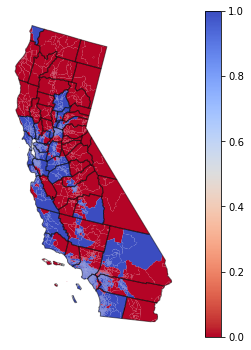

In [11]:
transit_tracts['Transit Accessible'] = (transit_tracts["Stop Count"] > 0)
axis = transit_tracts.plot("Transit Accessible", cmap="coolwarm_r", legend=True, edgecolor="none")
counties.plot(edgecolor="#00000080", facecolor="none", ax=axis)
axis.set_axis_off()
plt.show()

In [12]:
access_population = transit_tracts.groupby('Transit Accessible')['Total Population'].sum()
100 * access_population / transit_tracts['Total Population'].sum()

Transit Accessible
False    14.484024
True     85.515976
Name: Total Population, dtype: float64

In [13]:
transit_tracts.groupby("Transit Accessible")["Median Household Income"].describe()

,count,mean,std,min,25%,50%,75%,max
Transit Accessible,,,,,,,,
False,1144.0,72626.097902,33769.615225,21411.0,47326.25,63840.0,89315.5,218281.0
True,6821.0,83020.867468,40061.364411,7461.0,53617.00,75139.0,102868.0,250001.0


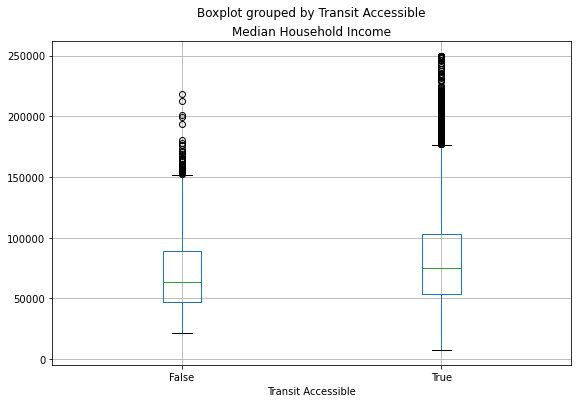

In [15]:
transit_tracts.boxplot("Median Household Income", "Transit Accessible")
plt.show()

"Distance decay is a spatial assumption that the power of the relationship between locations decreases as distance between locations increases" (https://michaelminn.net/tutorials/python-proximity).

"The US EPA's Toxics Release Inventory (TRI) is program that collects information reported annually by U.S. facilities in different industry sectors annually quantities of toxic chemical released to the air, water, or land disposal, and/or managed through recycling, energy recovery and treatment" (https://michaelminn.net/tutorials/python-proximity).

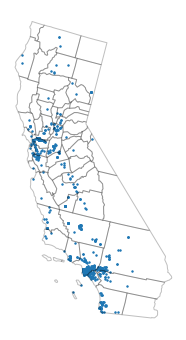

In [16]:
us_tri = pd.read_csv("https://data.epa.gov/efservice/downloads/tri/mv_tri_basic_download/2021_US/csv", low_memory=False)
points = gpd.points_from_xy(us_tri['13. LONGITUDE'], us_tri['12. LATITUDE'])
us_tri = gpd.GeoDataFrame(us_tri, geometry = points, crs='EPSG:4326')
us_tri = us_tri.to_crs(states.crs)
tri = us_tri[(us_tri['8. ST'] == analysis_state) & (us_tri['43. CARCINOGEN'] == "YES")]
axis = tri.plot(markersize=2)
counties.plot(edgecolor="#00000040", facecolor="none", ax=axis)
axis.set_axis_off()
plt.show()

Carcinogenic exposure in California is low except in the area immediately around Kings County and Colusa County.

Kings County has the highest estimated exposure to carcinogenic releases.

This is most likely because one of the largest naval master jet bases, NAS Leemore, is located in Kings County and is one of the largest employers in the area. NAS Leemore is permanently home to four different carrier air wings, so there is a lot of maintenance work to be done, which results in a high concentration of potentially carcinogenic materials in the area.

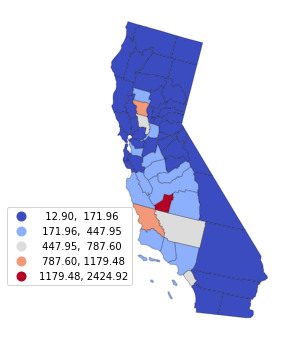

In [17]:
def area_exposure(area):
    x = tri['62. ON-SITE RELEASE TOTAL'] / \
        (1 + (tri.distance(area["geometry"].centroid) / 1000))**2
    return x.sum()

tri_counties = counties.copy()
tri_counties["Exposure lbs"] = tri_counties.apply(area_exposure, axis=1)
axis = tri_counties.plot('Exposure lbs',scheme="naturalbreaks", cmap="coolwarm", edgecolor="#00000040", legend=True, legend_kwds={"bbox_to_anchor":(0.2, 0.4)})
axis.set_axis_off()
plt.show()

In [18]:
tri_counties = tri_counties.sort_values('Exposure lbs', ascending=False).reset_index()
tri_counties[['Name', 'Exposure lbs']].head(n=10)

,Name,Exposure lbs
0,Kings,2424.915004
1,Colusa,1179.480781
2,San Luis Obispo,927.339455
3,Orange,787.602270
4,Kern,703.787749
5,Yolo,544.346455
6,Santa Barbara,447.952941
7,Fresno,363.577818
8,Tulare,347.705681
9,Los Angeles,313.393881


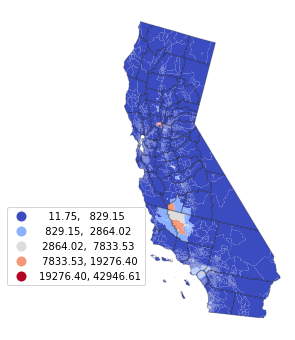

In [19]:
tri_tracts = tracts.copy()
tri_tracts["Exposure lbs"] = tri_tracts.apply(area_exposure, axis=1)
axis = tri_tracts.plot('Exposure lbs', scheme="naturalbreaks", cmap="coolwarm", edgecolor="none", legend=True, legend_kwds={"bbox_to_anchor":(0.2, 0.4)})
counties.plot(edgecolor="#00000040", facecolor="none", ax=axis)
axis.set_axis_off()
plt.show()